# Ejercicio Regression Tree
Son datos de temperaturas tomados de la ciudad de Seattle. El objetivo es intentar predecir lo mejor posible la máxima temperatura (columna `actual`) que alcanzaremos al día siguiente. Para ello contaremos con temperaturas de los dos días anteriores, históricos de máximas temperaturas y un amigo bastante chapas que te da su predicción del tiempo cada día.

**Resumen de datos**:
* year: 2016 for all data points
* month: number for month of the year
* day: number for day of the year
* week: day of the week as a character string
* temp_2: max temperature 2 days prior
* temp_1: max temperature 1 day prior
* average: historical average max temperature
* actual: max temperature measurement
* friend: your friend’s prediction, a random number between 20 below the average and 20 above the average

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error, mean_squared_error
from supertree import SuperTree

### 1. Importa el csv "temps.csv"

In [41]:
df = pd.read_csv('./data/temps.csv')
df.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [42]:
df.shape

(348, 12)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            348 non-null    int64  
 1   month           348 non-null    int64  
 2   day             348 non-null    int64  
 3   week            348 non-null    object 
 4   temp_2          348 non-null    int64  
 5   temp_1          348 non-null    int64  
 6   average         348 non-null    float64
 7   actual          348 non-null    int64  
 8   forecast_noaa   348 non-null    int64  
 9   forecast_acc    348 non-null    int64  
 10  forecast_under  348 non-null    int64  
 11  friend          348 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 32.8+ KB


In [44]:
df.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


mirar la media de la columna target para ver por donde tendra que ir el MAE

si se plantea como ST faltan días

### 2. Realiza un análisis exploratorio junto con un Feature Engineering

In [45]:
list(df.week.unique())

['Fri', 'Sat', 'Sun', 'Mon', 'Tues', 'Wed', 'Thurs']

In [46]:
day_map = {
    'Mon': 1,
    'Tues': 2,
    'Wed': 3,
    'Thurs': 4,
    'Fri': 5,
    'Sat': 6,
    'Sun': 7
}


In [47]:
# [key.lower() for key in day_map.keys()]

In [48]:
df['week_n'] = df['week'].apply(lambda x: day_map.get(x))
df.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_n
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29,5
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61,6
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56,7
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53,1
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41,2


In [49]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# le.fit(df.week)
# df['week_id'] = le.transform(df.week_n)

In [50]:
df.drop(columns=['week', 'year'], axis=0, inplace=True)
df.head()

,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_n
0,1,1,45,45,45.6,45,43,50,44,29,5
1,1,2,44,45,45.7,44,41,50,44,61,6
2,1,3,45,44,45.8,41,43,46,47,56,7
3,1,4,44,41,45.9,40,44,48,46,53,1
4,1,5,41,40,46.0,44,46,46,46,41,2


Agrupar por estaciones... si son pocas var mejor crear nuevas cols; mas le (10); mas trabajarlos mejor

In [51]:
df['otonio'] = np.where(df.month.isin([10, 11, 12]), 1, 0)   # lo que hace get dummies pero hay que agrupar pero en este caso no se puede xk nos interesan las temps sin agrupar
df['invierno'] = np.where(df.month.isin([1, 2, 3]), 1, 0)
df['primavera'] = np.where(df.month.isin([4, 5, 6]), 1, 0)
df['verano'] = np.where(df.month.isin([7, 8, 9]), 1, 0)

In [52]:
# sns.pairplot(df, kind='reg', diag_kind='hist', plot_kws={"line_kws": {"color": "red"}}, diag_kws={"color": 'green'})

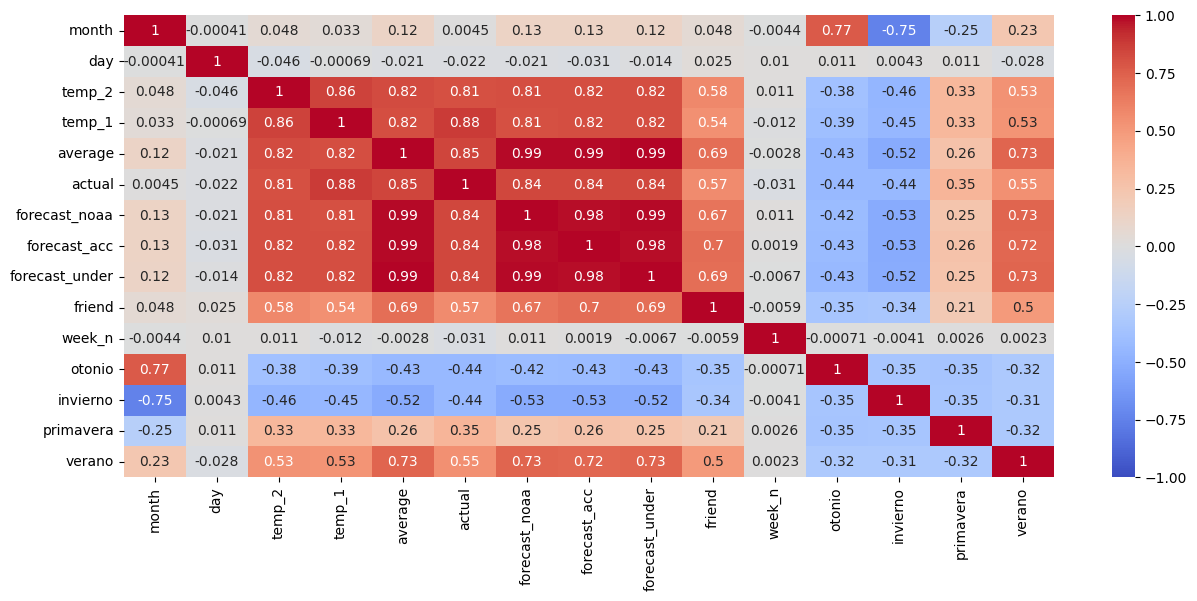

In [53]:
plt.figure(figsize=(15,6))
sns.heatmap(df.corr(numeric_only=True),
            vmin=-1,
            vmax=1,
            cmap="coolwarm",
            annot=True); 

### 3. Selecciona variables y divide en train y test

In [54]:
df.columns.values

array(['month', 'day', 'temp_2', 'temp_1', 'average', 'actual',
       'forecast_noaa', 'forecast_acc', 'forecast_under', 'friend',
       'week_n', 'otonio', 'invierno', 'primavera', 'verano'],
      dtype=object)

In [55]:
cols_diego =[ 'temp_1', 'average']

In [56]:
# X = df.drop(columns='actual', axis=1)
X = df[cols_diego]
y = df['actual']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

### 4. Entrena el modelo


si hacemos el modelo hasta el final (max_depth) el model.score da 0.99 y es mal - hay que pasar el MAX_DEPTH

In [58]:
decTreeReg_g2 = DecisionTreeRegressor(max_depth=2, random_state=10)

In [59]:
decTreeReg_g2.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2, random_state=10)

In [60]:
predictions = decTreeReg_g2.predict(X_test)

### 5. Evaluación de tu modelo
Calcula el coeficiente de determinación. 

Calcula el MAE, MAPE, MSE y RMSE.

In [61]:
print('coef de determinación (r2_score)', r2_score(y_test, predictions))
print('MAE:', mean_absolute_error(y_test, predictions))
print('MAPE:', mean_absolute_percentage_error(y_test, predictions))
print('MSE:', mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions)))

coef de determinación (r2_score) 0.7770001488181859
MAE: 4.790295289016972
MAPE: 0.08041353057357674
MSE: 35.205578138331234
RMSE: 5.933428868565901


In [62]:
X.columns.values

array(['temp_1', 'average'], dtype=object)

### 6. Representa el árbol de decisión

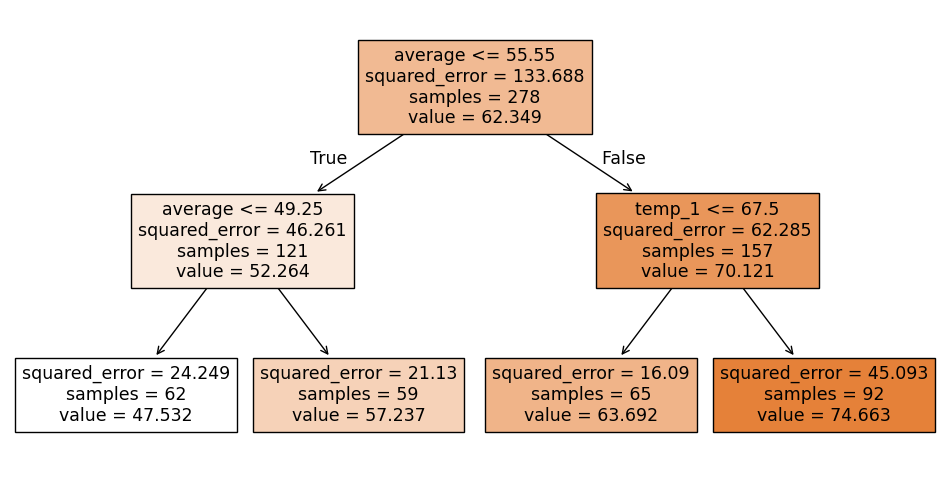

In [63]:
plt.figure(figsize=(12, 6))
plot_tree(decTreeReg_g2,
          feature_names=X.columns.values,
          class_names=df.actual.values,
        filled=True);

### 7. Modifica el max_depth a 3 y vuelve a entrenarlo

In [64]:
decTreeReg_g3 = DecisionTreeRegressor(max_depth=3, random_state=10)
decTreeReg_g3.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=10)

In [65]:
predictions_3 = decTreeReg_g3.predict(X_test)

### 8. Vuelve a evaluar tu modelo

In [66]:
print('Coef de determinación (r2_csore):', r2_score(y_test, predictions_3))
print('MAE:', mean_absolute_error(y_test, predictions_3))
print('MAPE:', mean_absolute_percentage_error(y_test, predictions_3))
print('MSE:', mean_squared_error(y_test, predictions_3))                # ha bajado, bien y el MAE tmb, generaliza mejor, y no llega a overfit
print('RMSE:', np.sqrt(mean_squared_error(y_test, predictions_3)))

Coef de determinación (r2_csore): 0.8453589334950944
MAE: 3.8580140930831206
MAPE: 0.06221658327719937
MSE: 24.413595441346715
RMSE: 4.941011580774398


### 9. Vuelve a representar su árbol

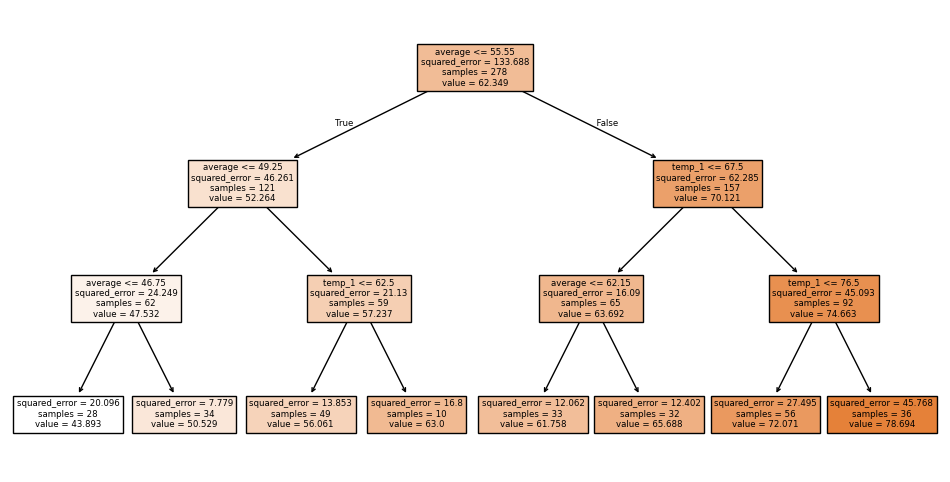

In [67]:
plt.figure(figsize=(12,6))
plot_tree(decTreeReg_g3,
          feature_names=list(X.columns.values),
          class_names=df.actual.values, filled=True);

### 10. Utiliza un grid search con cross validation para hiperparametrizar tu modelo

In [ ]:
dectreeReg = DecisionTreeRegressor(random_state=10)

params = {
    "max_depth": [2, 3, 4, 5, 6, 7],
    "criterion": ["sqaured_error", "absolute_error"],
}

gs = GridSearchCV(dectreeReg, params, scoring="neg_mean_absolute_error", cv=5)
gs.fit(X_train, y_train)

c:\Users\Ana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\Ana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=10),
             param_grid={'criterion': ['sqaured_error', 'absolute_error'],
                         'max_depth': [2, 3, 4, 5, 6, 7]},
             scoring='neg_mean_absolute_error')

In [72]:
print('mejor param:', gs.best_params_['max_depth'])
print('mejor MAE:', gs.best_score_)

mejor param: 4
mejor MAE: -4.047824675324675


In [73]:
best_model = gs.best_estimator_
pred_best_model = best_model.predict(X_test)

In [74]:
print('Mae:', mean_absolute_error(y_test, pred_best_model))

Mae: 3.7785714285714285


### 11. Obten el `feature_importances` de cada variable en el último modelo

In [75]:
#1_usa_housing

pd.DataFrame({
    'features': X.columns.values,
    'importance': best_model.feature_importances_,
}).sort_values(by='importance', ascending=False)

,features,importance
1,average,0.722973
0,temp_1,0.277027


### 12. Construye un nuevo modelo `DecisionTreeClassifier` que te clasifique cuando en un día va a hacer una temperatura mayor a 15ºC. ¡Deberá tratarse como un problema de **clasificación**! Utiliza un grid search con cross validation y evalúa el mejor modelo.

In [40]:
df.head()

,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_n
0,1,1,45,45,45.6,45,43,50,44,29,5
1,1,2,44,45,45.7,44,41,50,44,61,6
2,1,3,45,44,45.8,41,43,46,47,56,7
3,1,4,44,41,45.9,40,44,48,46,53,1
4,1,5,41,40,46.0,44,46,46,46,41,2


In [ ]:
# df['target_mayor_15grados'] = np.where(df['actual']> 59, 1, 0)

In [76]:
# 15 grados = 59 Fahrenreit
df['mayor15G'] = df['actual'].apply(lambda x: 1 if x > 59 else 0)
df[df['actual'] > 59].head()


,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,week_n,otonio,invierno,primavera,verano,mayor15G
39,2,9,51,57,49.4,62,45,52,49,57,2,0,1,0,0,1
51,2,23,51,51,50.7,60,49,53,51,43,2,0,1,0,0,1
53,2,25,60,59,50.9,61,49,51,49,35,4,0,1,0,0,1
54,2,26,59,61,51.1,60,48,56,53,65,5,0,1,0,0,1
61,3,5,59,57,52.1,64,49,53,51,46,6,0,1,0,0,1


In [ ]:
df.mayor15G.value_counts(normalize=True)   # no tan mal

mayor15G
1    0.586207
0    0.413793
Name: proportion, dtype: float64

In [78]:
X = df[['forecast_noaa', 'forecast_acc', 'forecast_under', 'month', 'day', 'week_n']]
X = df[['average', 'temp_1']]
y = df['mayor15G']

In [79]:
X.head()

,average,temp_1
0,45.6,45
1,45.7,45
2,45.8,44
3,45.9,41
4,46.0,40


In [80]:
y

0      0
1      0
2      0
3      0
4      0
      ..
343    0
344    0
345    0
346    0
347    0
Name: mayor15G, Length: 348, dtype: int64

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [82]:
decTreeClf = DecisionTreeClassifier()

params_clf = {
    "max_depth": [2, 3, 4 ,5, 6, 7],
    "min_samples_leaf": [2, 4, 6, 8],
}

gs_clf = GridSearchCV(decTreeClf, params_clf, scoring="accuracy", cv=5, verbose=3)
gs_clf.fit(X_train, y_train)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END ...max_depth=2, min_samples_leaf=2;, score=0.929 total time=   0.0s
[CV 2/5] END ...max_depth=2, min_samples_leaf=2;, score=0.804 total time=   0.0s
[CV 3/5] END ...max_depth=2, min_samples_leaf=2;, score=0.911 total time=   0.0s
[CV 4/5] END ...max_depth=2, min_samples_leaf=2;, score=0.855 total time=   0.0s
[CV 5/5] END ...max_depth=2, min_samples_leaf=2;, score=0.891 total time=   0.0s
[CV 1/5] END ...max_depth=2, min_samples_leaf=4;, score=0.929 total time=   0.0s
[CV 2/5] END ...max_depth=2, min_samples_leaf=4;, score=0.804 total time=   0.0s
[CV 3/5] END ...max_depth=2, min_samples_leaf=4;, score=0.911 total time=   0.0s
[CV 4/5] END ...max_depth=2, min_samples_leaf=4;, score=0.855 total time=   0.0s
[CV 5/5] END ...max_depth=2, min_samples_leaf=4;, score=0.891 total time=   0.0s
[CV 1/5] END ...max_depth=2, min_samples_leaf=6;, score=0.929 total time=   0.0s
[CV 2/5] END ...max_depth=2, min_samples_leaf=6

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': [2, 4, 6, 8]},
             scoring='accuracy', verbose=3)

In [84]:
print('mejor param', gs_clf.best_params_['max_depth'])
print('mejor accuracy:', gs_clf.best_score_)

mejor param 6
mejor accuracy: 0.8848051948051948


In [86]:
gs_clf.best_score_

np.float64(0.8848051948051948)

In [ ]:
model_fin = gs.best_estimator_

model_fin.predict([[52, 49.2]])     # temperatura con Regression

c:\Users\Ana\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([51.])

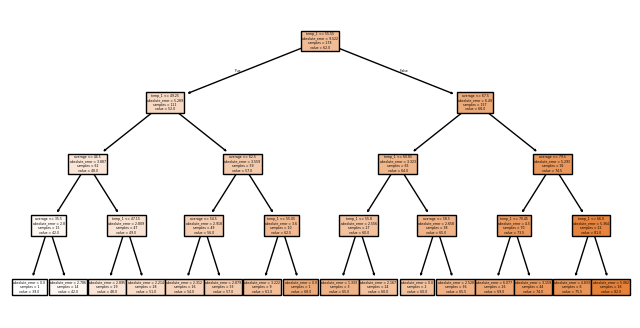

In [85]:
plt.figure(figsize=(8,4))
plot_tree(gs.best_estimator_, feature_names=list(X.columns), class_names=['< 15', '> 15'], filled=True)
plt.show();

In [67]:
# este no se yo... mañana lo consulto
feature_names = list(X.columns)
label_mapping = {0: '< 15', 1: '> 15'}
target_names = [label_mapping[label] for label in y]
# set(target_names)

super_tree = SuperTree(gs.best_estimator_, X, y, feature_names, target_names)
super_tree.show_tree()

### 13. Construye un nuevo modelo `RandomForestClassifier` que te clasifique cuando en un día va a hacer una temperatura mayor a 15ºC. ¡Deberá tratarse como un problema de **clasificación**! Utiliza un grid search con cross validation y evalúa el mejor modelo.